In [1]:
# install libraries
!pip install scikit-learn transformers opencv-python matplotlib torch pillow faiss-cpu
!pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /private/var/folders/sm/xdqhn25x4j555b_4m204nff00000gn/T/pip-req-build-pokardb9
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /private/var/folders/sm/xdqhn25x4j555b_4m204nff00000gn/T/pip-req-build-pokardb9
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


## Import libraries and modules

In [2]:
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import os
import matplotlib.pyplot as plt
import cv2
import torch
from transformers import AutoImageProcessor, ResNetModel
import clip
from PIL import Image
import faiss

## Dataset Analysis

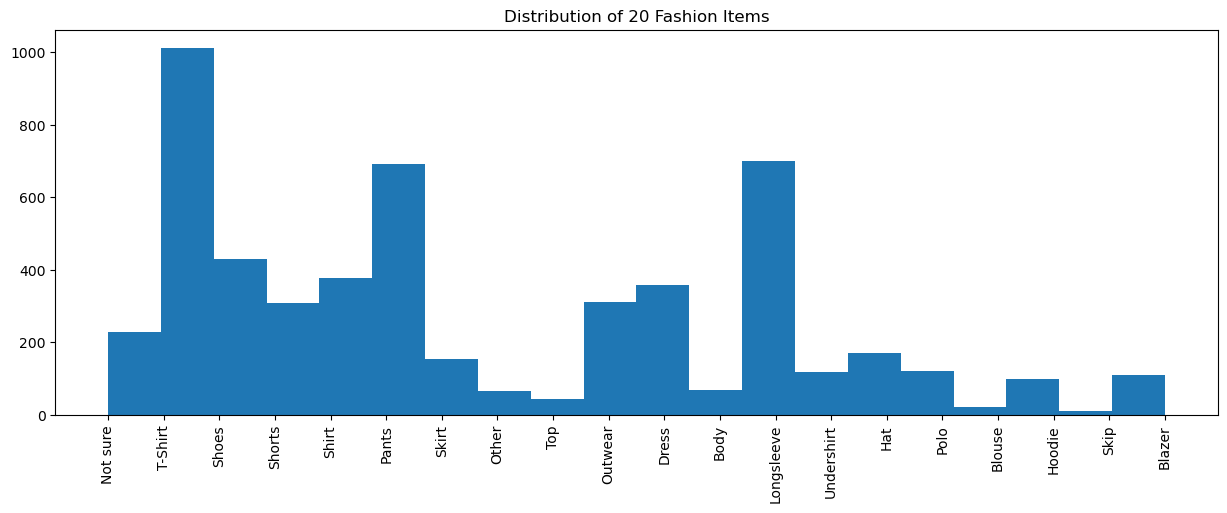

In [3]:
# load the dataset
data = pd.read_csv('images.csv')

# analysis
image_ids = data['image'].tolist()
labels = data['label'].tolist()
kids = data['kids'].tolist()
unique_items = set(labels)

# visualize the different categories of fashion items
plt.figure(figsize=(15, 5))
plt.title("Distribution of {} Fashion Items".format(len(unique_items)))
plt.hist(labels, bins=len(unique_items))
plt.xticks(rotation=90)
plt.show()

## Data cleansing

In [4]:
# remove the records with the label Skip, because the images with skip labels are not present in the images folder or occluded
data = data[data['label'] != 'Skip']
image_ids = data['image'].tolist()
labels = data['label'].tolist()
kids = data['kids'].tolist()
unique_items = set(labels)

## Load the ResNet-50 model for image features extraction

In [5]:
# load the resnet model for image features extraction
model_name = "microsoft/resnet-50"
resnet_img_processor = AutoImageProcessor.from_pretrained(model_name)
resnet_model = ResNetModel.from_pretrained(model_name)

## Load the clip model for extracting image and text query feature embeddings

In [6]:
clip_model, clip_preprocess = clip.load("ViT-B/32", "cpu")

## Helper functions

In [35]:
"""
This function returns the feature vector for the image passed using the pre-trained ResNet-50 model
"""
def extract_image_features(img_path):
  # load and preprocess the image for the ResNet model
  image = cv2.imread(img_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  # resize the image to 224x224 to be compatible with ResNet model input size
  image = cv2.resize(image, (224, 224))
  # convert the image to PyTorch tensor and change dimensions to CxHxW as expected by the ResNet model
  image = torch.tensor(image).permute(2, 0, 1).float()
  inputs = resnet_img_processor(images=[image], return_tensors="pt")

  # forward pass to get features without the final classification layer
  with torch.no_grad():
    outputs = resnet_model(**inputs)

  # use the last convolutional layer output as feature vector
  # it is a 2048-dimensional vector
  feature_vector = outputs.pooler_output.squeeze()

  return feature_vector

"""
This function returns the feature vector for the image passed using the pre-trained CLIP model
"""
def extract_image_semantic_features(img_path):
  image = Image.open(img_path)
  # preprocess the image for the CLIP model
  image = clip_preprocess(image).unsqueeze(0).to("cpu")
  # disable gradient calculation
  with torch.no_grad():
    # get the image embedding
    image_features = clip_model.encode_image(image)
    # normalize the image embeddings to be between 0 and 1
    image_features = image_features / image_features.norm(dim=-1, keepdim=True)
  return image_features.cpu().numpy().squeeze()


"""
This function returns the feature vector for the text query passed using the pre-trained CLIP model text encoder
"""
def encode_text_query(query):
  text = clip.tokenize([query]).to("cpu")
  with torch.no_grad():
    text_features = clip_model.encode_text(text)
    text_features = text_features / text_features.norm(dim=-1, keepdim=True)
  return text_features.cpu().numpy().squeeze()


"""
This function returns image recommendations based on COSINE similarity.
It calculates similarity scores between the test image and dataset images, optionally combined with a text query for semantic filtering.
"""
def get_recommendations_cosine_similarity(test_img_path, count=5, query=""):
  # get feature vector for the test image
  test_img_features = extract_image_features(test_img_path)
  # calculate similarity scores between the test image and all the images in the dataset
  similarity_scores = cosine_similarity([test_img_features], feature_vectors_matrix).flatten()
  # make sure the test image is not returned as recommended
  similarity_scores = np.where(similarity_scores == 1.0, 0, similarity_scores)

  # filter by query if supplied
  if query:
    query_features = encode_text_query(query)
    # calculate similarity scores between the text query and all the images in the dataset
    text_similarities = cosine_similarity([query_features], semantic_feature_vectors_matrix).flatten()
    # combine the similarity scores from image and text, giving more weight to query similarity scores to filter results
    similarity_scores = 0.2 * similarity_scores + 0.8 * text_similarities

  # sort the similarity scores in descending order, meaning similar items will show up first
  similar_indices = np.argsort(similarity_scores)[::-1]
  return similar_indices[:count]


"""
This function returns image recommendations based on Euclidean distances
between the test image (optionally combined with a text query embedding for semantic filtering) and the dataset images CLIP embeddings.
"""
def get_recommendations_euclidean(test_img_path, count=5, query=""):
  # get the clip semantic embedding for the test image
  test_img_embedding = extract_image_semantic_features(test_img_path).reshape(1, -1)
  test_embedding = test_img_embedding

  # optional query supplied, add that to the test embedding
  if query:
    # get the clip semantic embedding for the query
    text_embedding = encode_text_query(query).reshape(1, -1)
    # modify the test embedding by combining it with text query embedding in equal weightage
    test_embedding = 0.5 * test_img_embedding + 0.5 * text_embedding

  # calculate Euclidean distances between the dataset images and the test embedding (both image and query if supplied)
  distances = np.linalg.norm(semantic_feature_vectors_matrix - test_embedding, axis=1)

  # filter out the test image itself
  test_image_name = os.path.basename(test_img_path).split('.')[0]
  if test_image_name in image_ids:
    test_img_index = image_ids.index(test_image_name)
    # increase the distance for the test image to infinity so that it isn't returned as recommendation
    distances[test_img_index] = np.inf

  # return the recommendations indexes
  similar_indices = np.argsort(distances)[:count]
  return similar_indices


"""
This function returns image recommendations using Facebook AI Similarity Search library which is suitable for high dimensional vectors and does efficient retrieval
"""
def get_recommendations_faiss(test_img_path, count=5):
  # get feature vector for the test image
  test_img_features = extract_image_features(test_img_path)
  # convert the tensor to 2D array
  test_img_features = test_img_features.reshape(1, -1)
  feature_dimension = test_img_features.shape[1]
  # create FAISS index to find similar images indexes by calculating the Euclidean distance (L2 distance) between feature vectors
  image_index = faiss.IndexFlatL2(feature_dimension)
  # add dataset images vectors to the index
  image_index.add(feature_vectors_matrix)
  # perform the similarity search
  distances, indices = image_index.search(test_img_features, count + 1)
  indices = indices.flatten().astype(int)

  return indices[:count]


def get_and_display_recommendations(test_img_path, recommendations_count=5, algorithm="cosine_similarity", query=""):
  # load the test image
  test_img = cv2.imread(test_img_path)
  test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

  # get the recommended images against the test image using the algorithm specified
  if algorithm == "faiss":
    recommended_img_indexes = get_recommendations_faiss(test_img_path, recommendations_count)
  elif algorithm == "euclidean":
    recommended_img_indexes = get_recommendations_euclidean(test_img_path, recommendations_count, query)
  else:
    # default algorithm is cosine similarity
    recommended_img_indexes = get_recommendations_cosine_similarity(test_img_path, recommendations_count, query)

  recommended_images = [(cv2.imread(os.path.join("images", image_ids[idx] + ".jpg"))) for idx in
                        recommended_img_indexes]

  subplots_count = recommendations_count + 1
  # plot the test image
  plt.figure(figsize=(15, 5))
  plt.subplot(1, subplots_count, 1)
  plt.imshow(test_img)
  plt.title("Test")
  plt.axis('off')

  # plot the recommended images
  for i, img in enumerate(recommended_images):
    plt.subplot(1, subplots_count, i + 2)
    # convert the image to RGB format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.title("Recommended " + str(i + 1))
    plt.axis('off')


plt.tight_layout()
plt.show()

<Figure size 640x480 with 0 Axes>

## Extract features for all the images in the dataset

In [8]:
# extract Resnet50 features for the images in the dataset
feature_vectors = [extract_image_features(os.path.join("images", img_id + ".jpg")) for img_id in image_ids]

In [9]:
# extract CLIP features for the images in the dataset
semantic_feature_vectors = [extract_image_semantic_features(os.path.join("images", img_id + ".jpg")) for img_id in image_ids]

In [10]:
# Resnet feature vectors
print("ResNet feature vectors for all the {} images".format(len(feature_vectors)))
print("Feature Shape", feature_vectors[0].shape)

# CLIP feature vectors
print("CLIP feature vectors for all the {} images".format(len(semantic_feature_vectors)))
print("Feature Shape", semantic_feature_vectors[0].shape)

ResNet feature vectors for all the 5391 images
Feature Shape torch.Size([2048])
CLIP feature vectors for all the 5391 images
Feature Shape (512,)


In [11]:
# calculate cosine similarity between the feature vectors
feature_vectors_matrix = np.stack(feature_vectors)
semantic_feature_vectors_matrix = np.stack(semantic_feature_vectors)
# save the feature matrices to a file
np.save("embeddings/resnet_feature_matrix.npy", feature_vectors_matrix)
np.save("embeddings/clip_feature_matrix.npy", semantic_feature_vectors_matrix)
print(feature_vectors_matrix.shape)
print(semantic_feature_vectors_matrix.shape)

(5391, 2048)
(5391, 512)


## Load the features matrix

In [12]:
# load the feature matrix
feature_vectors_matrix = np.load("embeddings/resnet_feature_matrix.npy")
semantic_feature_vectors_matrix = np.load("embeddings/clip_feature_matrix.npy")

## Test the recommendation system

### 1. COSINE SIMILARITY ALGORITHM on ResNet50 for general similarity and CLIP for query filtering

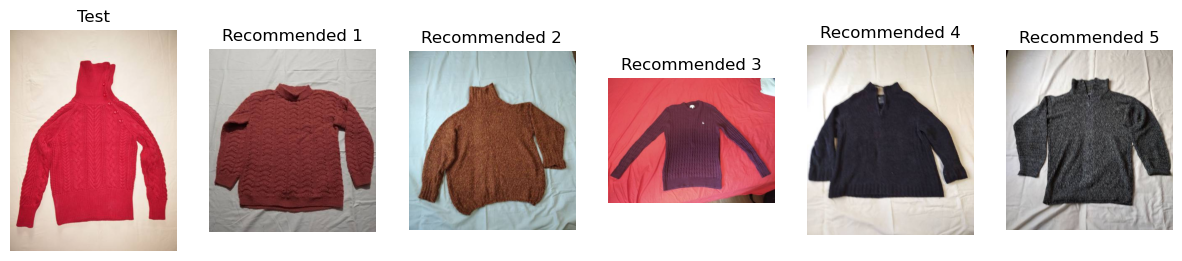

In [13]:
test_img_path = os.path.join("images", "0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg")
get_and_display_recommendations(test_img_path, recommendations_count=5, algorithm="cosine_similarity")

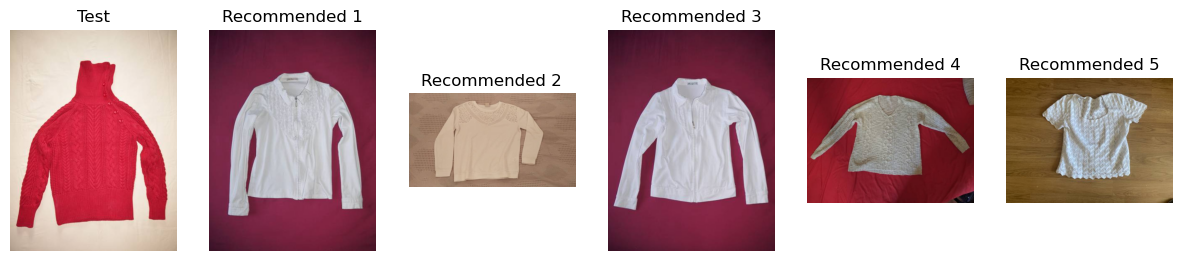

In [14]:
test_img_path = os.path.join("images", "0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg")
# further filtering e.g. sleeveless, grey, white, puffer, women jackets
get_and_display_recommendations(test_img_path, recommendations_count=5, algorithm="cosine_similarity", query="white")

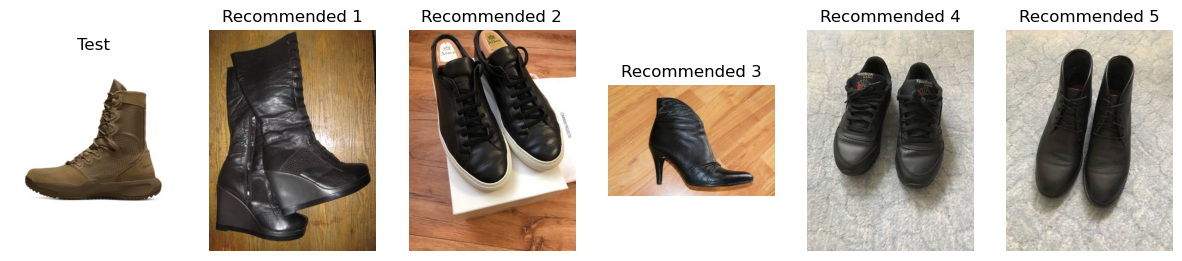

In [32]:
test_img_path = os.path.join("test_images", "2.jpg")
# further filtering e.g. white, black, grey
get_and_display_recommendations(test_img_path, recommendations_count = 5, algorithm="cosine_similarity", query="black")

### 2.Euclidean Distance Algorithm on CLIP embeddings for both test image and query

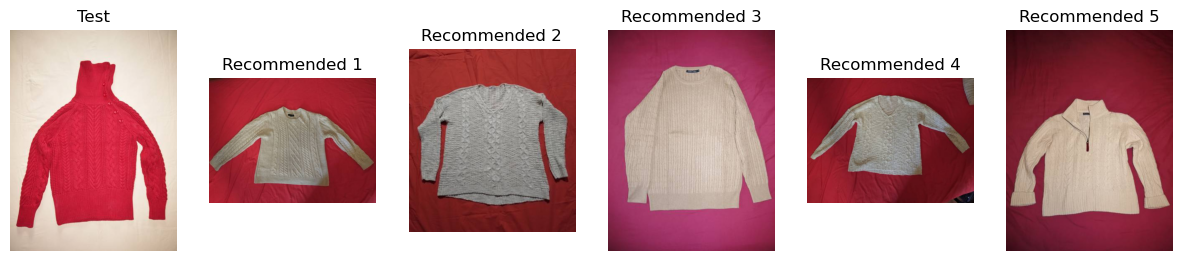

In [26]:
test_img_path = os.path.join("images", "0a671f9d-d105-4ec9-8642-f4f228f8a90f.jpg")
# further filtering e.g. sleeveless, grey, white, puffer, women jackets
get_and_display_recommendations(test_img_path, recommendations_count=5, algorithm="euclidean", query="white")

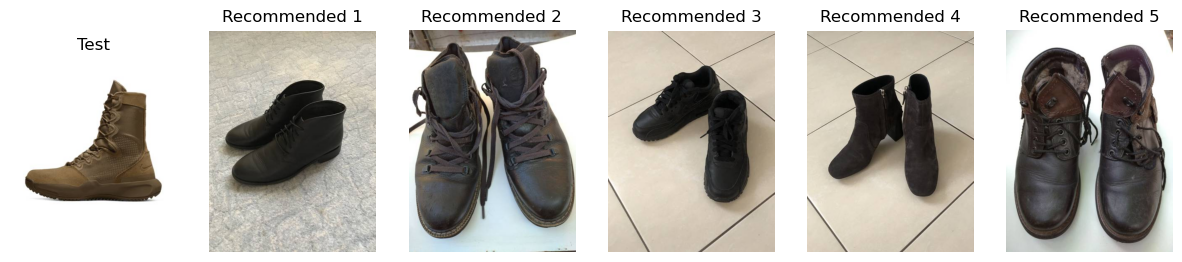

In [31]:
test_img_path = os.path.join("test_images", "2.jpg")
# further filtering e.g. white, black, grey
get_and_display_recommendations(test_img_path, recommendations_count = 5, algorithm="euclidean", query="black")

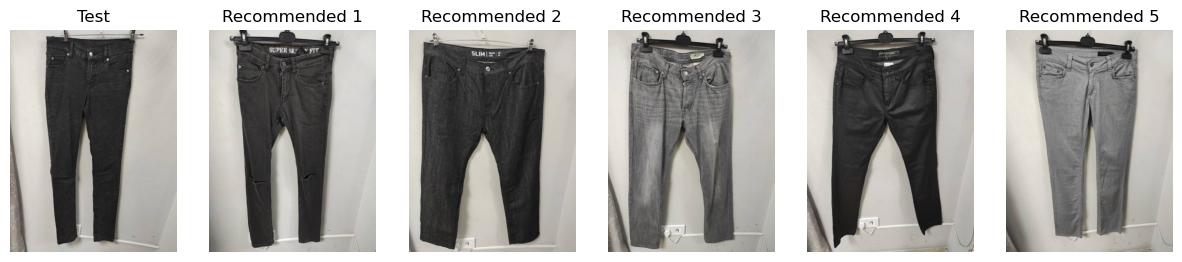

In [28]:
test_img_path = os.path.join("images", "1a08f33a-2ff4-4fb8-920b-8ff514bcdda8.jpg")
# further blue, black
get_and_display_recommendations(test_img_path, recommendations_count = 5, algorithm="euclidean")

### 3. FAISS (Facebook AI Similarity Search) Algorithm without filtering

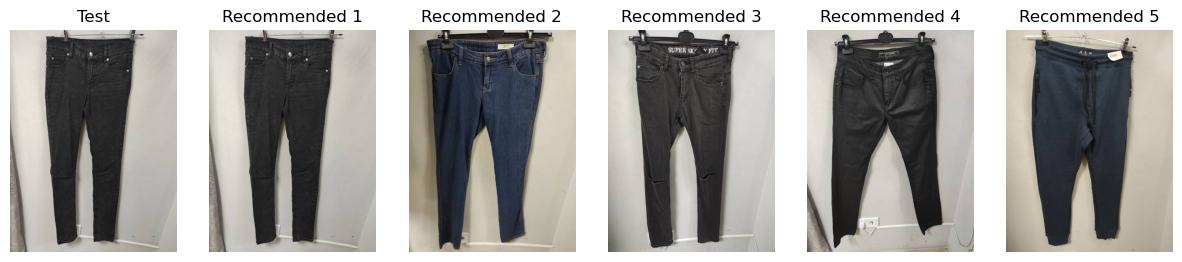

In [19]:
test_img_path = os.path.join("images", "1a08f33a-2ff4-4fb8-920b-8ff514bcdda8.jpg")
# further blue, black
get_and_display_recommendations(test_img_path, recommendations_count = 5, algorithm="faiss")

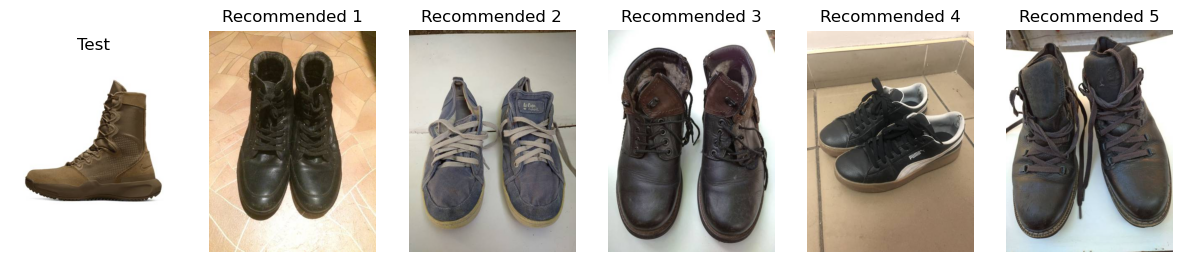

In [34]:
test_img_path = os.path.join("test_images", "2.jpg")
# further filtering e.g. white, black, grey
get_and_display_recommendations(test_img_path, recommendations_count = 5, algorithm="faiss")